# VI — Matchmaking - An Optimal Transport Case Study


Suppose we have two groups of people participating in speed dating event.

- For each person we can build a feature vector (age, interests, stated preferences, etc.).
- For any pair (person from group A, person from group B), we can compute a compatibility cost: low cost means "good match".

What we want: a *global* matching policy that answers:

> "How should *mass* (attention / recommendations) flow from group A to group B to minimize total incompatibility, while treating everyone fairly?"

Optimal Transport is a natural fit because it enforces global consistency:
- Everyone in group A must distribute all their mass.
- Everyone in group B must receive the right total mass.

This prevents a common failure mode of naive scoring systems: everyone gets matched to the same few "top" profiles.


A common baseline is:

1. Score every possible pair.
2. For each person, recommend the top-*k* matches by score.

This is not a valid matching policy at the population level:
- It ignores competition (many people choose the same top profiles).
- It ignores scarcity (limited attention / limited capacity).
- It can create extreme exposure imbalance (a few people receive nearly all recommendations).

Optimal Transport fixes this by adding *hard constraints* (marginals) and solving a global optimization.


### Data source

We use the public SpeedDating dataset (participants in speed dating events, 2002–2004)  [Link](https://www.openml.org/search?type=data&sort=runs&id=40536&status=active)

Each row corresponds to an interaction (a date) between two participants and includes:
- participant id (`iid`) and partner id (`pid`)
- participant attributes (e.g. `age`, `field`, ...)
- participant stated preference weights (e.g. how much they value attractiveness, sincerity, ...)
- partner ratings (e.g. `attr_o`, `intel_o`, ...)
- decision / match outcome (e.g. `dec`, `match`)


In [1]:
#!pip install POT


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import StandardScaler
import ot
ot.__version__


'0.9.6.post1'

In [3]:
# Load the Speed Dating dataset 
df = pd.read_csv('data/SpeedDating.csv')
df.shape, df.columns[:20]

((8378, 123),
 Index(['has_null', 'wave', 'gender', 'age', 'age_o', 'd_age', 'd_d_age',
        'race', 'race_o', 'samerace', 'importance_same_race',
        'importance_same_religion', 'd_importance_same_race',
        'd_importance_same_religion', 'field', 'pref_o_attractive',
        'pref_o_sincere', 'pref_o_intelligence', 'pref_o_funny',
        'pref_o_ambitious'],
       dtype='object'))

## Build person-level feature vectors
The raw table is *interaction-level* (one row per date).
For OT we want *one vector per person*.

We'll construct a compact numeric feature vector per participant using:
- basic demographics (e.g. age)
- stated preference weights (e.g. how much they care about attractiveness / intelligence / etc.)

We then split into two distributions:
- $X = \{x_i\}$: men
- $Y = \{y_j\}$: women

(The dataset is heterosexual speed dating; we treat `gender` as the group indicator.)

In [4]:
df['gender'].value_counts(dropna=False).head()

gender
male      4194
female    4184
Name: count, dtype: int64

In [5]:
candidate_cols = [
 'gender', #Gender of self  
 'age', #Age of self  
 'race', #Race of self  
 'importance_same_race', #How important is it that partner is of same race?
 'importance_same_religion', #How important is it that partner has same religion?  
 'field', #Field of study  
 'pref_o_attractive', #How important does partner rate attractiveness  
 'pref_o_sincere', #How important does partner rate sincerity
 'pref_o_intelligence', #How important does partner rate intelligence
 'pref_o_funny', #How important does partner rate being funny
 'pref_o_ambitious', #How important does partner rate ambition  
 'pref_o_shared_interests', #How important does partner rate having shared interests  
 'attractive_important', #What do you look for in a partner - attractiveness  
 'sincere_important', #What do you look for in a partner - sincerity  
 'intellicence_important', #What do you look for in a partner - intelligence  
 'funny_important', #What do you look for in a partner - being funny  
 'ambtition_important', #What do you look for in a partner - ambition  
 'shared_interests_important', #What do you look for in a partner - shared interests  
 'attractive', #Rate yourself - attractiveness  
 'sincere', #Rate yourself - sincerity   
 'intelligence', #Rate yourself - intelligence   
 'funny', #Rate yourself - being funny   
 'ambition', #Rate yourself - ambition 
 'sports', #Your own interests [1-10]  
 'tvsports', #Your own interests [1-10]  
 'exercise', #Your own interests [1-10]  
 'dining', #Your own interests [1-10]  
 'museums', #Your own interests [1-10]  
 'art', #Your own interests [1-10]  
 'hiking', #Your own interests [1-10]  
 'gaming', #Your own interests [1-10]  
 'clubbing', #Your own interests [1-10]  
 'reading', #Your own interests [1-10]  
 'tv', #Your own interests [1-10]  
 'theater', #Your own interests [1-10]  
 'movies', #Your own interests [1-10]  
 'concerts', #Your own interests [1-10]  
 'music', #Your own interests [1-10]  
 'shopping', #Your own interests [1-10]  
 'yoga', #Your own interests [1-10]  
 'expected_happy_with_sd_people', #How happy do you expect to be with the people you meet during the speed-dating event?  
 'expected_num_interested_in_me', #Out of the 20 people you will meet, how many do you expect will be interested in dating you?  
 'expected_num_matches' #How many matches do you expect to get?  
]

not_available_cols = [c for c in candidate_cols if c not in df.columns]
available_cols = [c for c in candidate_cols if c in df.columns]
print("Not available columns:", not_available_cols)

Not available columns: []


In [6]:
df_relevant = df[available_cols].copy()
# check for missing values
df_relevant.isnull().sum()

# remove null values
df_relevant = df_relevant.dropna().reset_index(drop=True)
#df_relevant.isnull().sum()
df_relevant.shape

df_relevant

men = df_relevant[df_relevant["gender"] == 'female'].copy()
women = df_relevant[df_relevant["gender"] == 'male'].copy()

men = men.drop(columns=['gender'])
women = women.drop(columns=['gender'])

In [7]:
# preprocess df
def preprocess_mixed_table(df: pd.DataFrame, cols=None) -> pd.DataFrame:
    """
    Minimal preprocessing for mixed-type columns.

    Rules:
    1) Detect column type by inspection.
    2) Numeric columns: impute missing with MODE.
    3) "Range-of-integers" string columns (e.g. '6-10'): convert to midpoint float,
       then impute missing with MEDIAN.
    4) Categorical columns: one-hot encode; missing -> all zeros (i.e., no 'missing' dummy).

    Returns:
        A new DataFrame with:
          - numeric columns kept (imputed)
          - range columns converted to numeric (imputed)
          - categorical columns replaced by one-hot columns
    """
    df = df.copy()
    if cols is None:
        cols = list(df.columns)
    else:
        cols = [c for c in cols if c in df.columns]

    # --- helpers ---
    range_pat = re.compile(r"^\s*(\d+)\s*-\s*(\d+)\s*$")

    def is_range_string_series(s: pd.Series, sample_n=200, min_hits=3) -> bool:
        # detect columns that look like "6-10"
        x = s.dropna().astype(str)
        if len(x) == 0:
            return False
        x = x.sample(min(sample_n, len(x)), random_state=0)
        hits = sum(bool(range_pat.match(v)) for v in x)
        return hits >= min_hits

    def range_to_midpoint(v):
        if pd.isna(v):
            return np.nan
        if isinstance(v, (int, float, np.number)):
            return float(v)
        s = str(v).strip()
        m = range_pat.match(s)
        if m:
            lo, hi = float(m.group(1)), float(m.group(2))
            return 0.5 * (lo + hi)
        # try numeric string
        try:
            return float(s)
        except Exception:
            return np.nan

    out_parts = []

    for c in cols:
        s = df[c]

        # Numeric dtype → mode impute
        if pd.api.types.is_numeric_dtype(s):
            mode_vals = s.dropna().mode()
            fill = mode_vals.iloc[0] if len(mode_vals) else 0.0
            out_parts.append(s.fillna(fill).to_frame(c))
            continue

        # Object/category: check if it's mostly "a-b" integer range
        if is_range_string_series(s):
            s_num = s.apply(range_to_midpoint).astype(float)
            med = float(np.nanmedian(s_num.values)) if np.isfinite(s_num.values).any() else 0.0
            out_parts.append(s_num.fillna(med).to_frame(c))
            continue

        # Otherwise treat as categorical: one-hot; missing => all zeros
        s_cat = s.astype("object")
        dummies = pd.get_dummies(s_cat, prefix=c, dummy_na=False).astype(int)
        # Ensure missing rows become all-zeros
        missing_mask = s_cat.isna()
        if missing_mask.any() and dummies.shape[1] > 0:
            dummies.loc[missing_mask, :] = 0
        out_parts.append(dummies)

    return pd.concat(out_parts, axis=1)



In [8]:
df_preprocessed = preprocess_mixed_table(df_relevant)
print(df_preprocessed.shape)
print(df_preprocessed.isna().sum().sort_values(ascending=False).head())
non_numeric = df_preprocessed.select_dtypes(exclude=[np.number]).columns
print(non_numeric)

men = df_preprocessed[df_preprocessed["gender_male"] == 1].copy()
women = df_preprocessed[df_preprocessed["gender_female"] == 1].copy()

men = men.drop(columns=['gender_male', 'gender_female'])
women = women.drop(columns=['gender_male', 'gender_female'])

(1452, 103)
gender_female             0
field_psychology          0
funny_important           0
intellicence_important    0
sincere_important         0
dtype: int64
Index([], dtype='object')


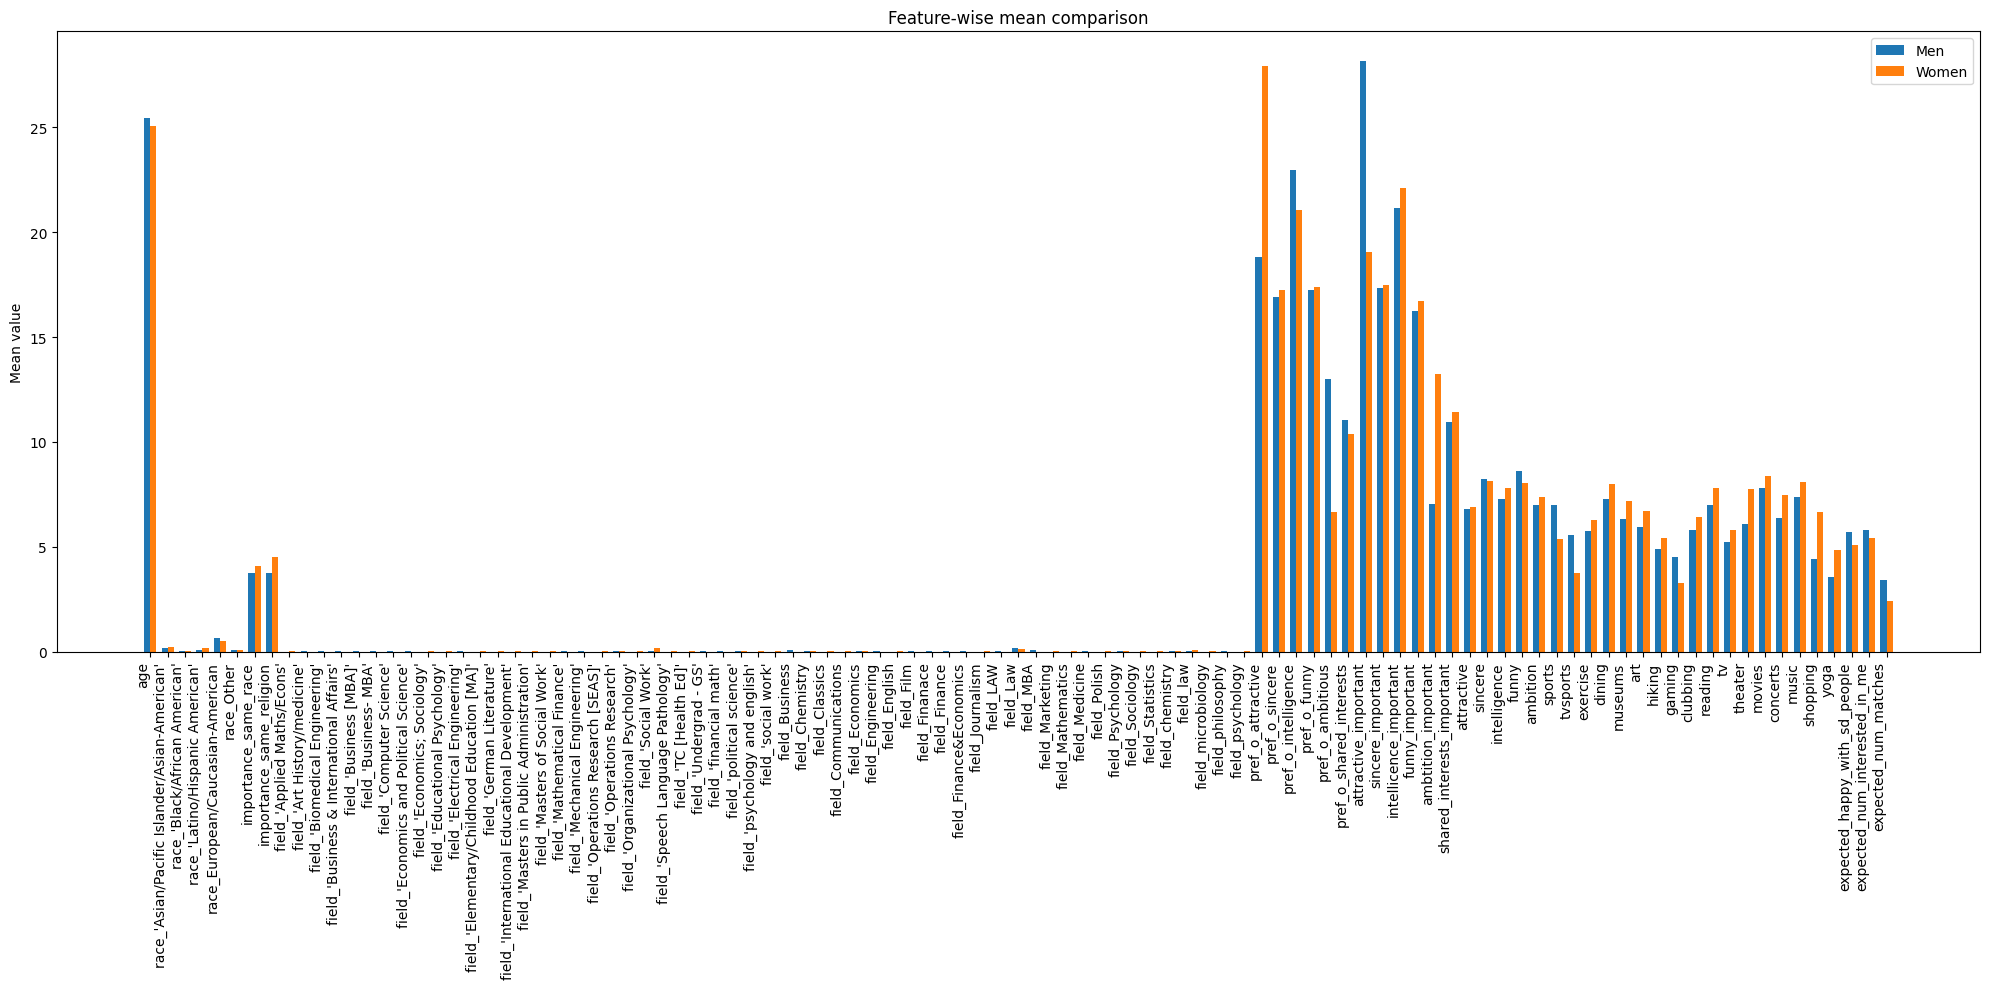

In [9]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)


men_desc = men.describe().T
women_desc = women.describe().T

# Add top-level column labels
men_desc.columns = pd.MultiIndex.from_product([["Men"], men_desc.columns])
women_desc.columns = pd.MultiIndex.from_product([["Women"], women_desc.columns])

# Concatenate side by side
desc_side_by_side = pd.concat([men_desc, women_desc], axis=1)

desc_side_by_side

import matplotlib.pyplot as plt

features = men_desc.index  # or a subset list

men_means = men_desc[("Men", "mean")]
women_means = women_desc[("Women", "mean")]

x = range(len(features))
width = 0.35

plt.figure(figsize=(20, 10))
plt.bar(x, men_means, width, label="Men")
plt.bar([i + width for i in x], women_means, width, label="Women")

plt.xticks([i + width/2 for i in x], features, rotation=90, ha="right")
plt.ylabel("Mean value")
plt.title("Feature-wise mean comparison")
plt.legend()
plt.tight_layout()
plt.show()



In [10]:
X_raw.shape, Y_raw.shape


NameError: name 'X_raw' is not defined

In [ ]:
X_raw = men.values
Y_raw = women.values

# Standardize features (important for Euclidean costs)
scaler = StandardScaler()
scaler.fit(np.vstack([X_raw, Y_raw]))

X = scaler.transform(X_raw)
Y = scaler.transform(Y_raw)

X.shape, Y.shape

((718, 101), (734, 101))

### Formulation: 

We have two populations represented as feature vectors embedded in a shared metric space:

- Men: $X = \{x_i \in \mathbb{R}^d\}_{i=1}^n$
- Women: $Y = \{y_j \in \mathbb{R}^d\}_{j=1}^m$

Each vector is a standardized profile (e.g., age, preferences, interests). Our goal is not to predict individual outcomes, but to compute a globally consistent, population-level matching between the two distributions.


#### Cost Function 

We define a pairwise compatibility cost:
$$
C_{ij} = \|x_i - y_j\|_2^2
$$

Lower cost indicates higher similarity.  
The cost matrix $C$ is fixed and exogenous; defining it is a modeling choice made prior to optimization.

#### Decision Variable

We optimize over a transport plan:
$$
\Pi \in \mathbb{R}_+^{n \times m}
$$

$\Pi_{ij}$ represents the *amount of probability mass* assigned between man $i$ and woman $j$.  
$\Pi$ is a soft coupling (a joint distribution over pairs), not a one-to-one assignment.


#### Marginal Constraints (Population Balance)

Let $a \in \Delta^n$ and $b \in \Delta^m$ be probability weights (typically uniform):
$$
a_i = \tfrac{1}{n}, \quad b_j = \tfrac{1}{m}
$$

The transport plan must satisfy:
$$
\Pi \mathbf{1}_m = a, \qquad \Pi^\top \mathbf{1}_n = b
$$

Thus, each individual contributes and receives the correct total mass in aggregate.


### Optimal Transport Objective

Unregularized OT (Linear Program):
$$
\min_{\Pi \ge 0} \ \langle C, \Pi \rangle
\quad \text{s.t.} \quad
\Pi \mathbf{1}_m = a,\ \Pi^\top \mathbf{1}_n = b
$$

This is a linear program. Its solutions often lie at sparse extreme points and may be non-unique.


### Entropic Optimal Transport (Regularized, Practical)

To obtain a smooth, stable, and computationally efficient solution, we add entropy regularization:
$$
\min_{\Pi \ge 0} \ \langle C, \Pi \rangle - \varepsilon H(\Pi),
\qquad
H(\Pi) = -\sum_{i,j} \Pi_{ij}\log \Pi_{ij}
$$

Equivalently:
$$
\min_{\Pi \ge 0} \ \langle C, \Pi \rangle + \varepsilon \sum_{i,j} \Pi_{ij}(\log \Pi_{ij}-1)
$$

where $\varepsilon > 0$ controls the smoothness of the matching.

This problem is strictly convex (under mild conditions) and admits a unique solution. This is a well-defined convex optimization problem and is solved with Sinkhor iteration algorithm.

> Sinkhorn iterations are the numerical algorithm used to compute the solution of the entropically regularized optimal transport problem.

- Decision variable: $\Pi$ (a joint distribution over pairs)
- Objective: minimize total mismatch cost while encouraging smooth matchings
- Constraints: preserve population-level balance
- Problem class: convex optimization  
  - unregularized OT: linear program  
  - entropic OT: strictly convex, efficiently solvable


In [ ]:
import numpy as np
import ot  # POT

n, m = X.shape[0], Y.shape[0]
a = np.ones(n) / n
b = np.ones(m) / m

# Compute the cost matrix C_ij = ||x_i - y_j||^2
# POT provides fast distance computation:
C = ot.dist(X, Y, metric="euclidean") ** 2   # shape (n, m)


# Optional: cost normalization (often improves numerical stability)
C = C / C.max()

# Choose entropy regularization strength (epsilon)
# Larger reg => smoother plan; smaller reg => sharper plan but more numerically sensitive
reg = 0.001  

# Solve entropic OT with Sinkhorn
Pi = ot.sinkhorn(a, b, C, reg, numItermax=5000, stopThr=1e-9)

Pi.shape, Pi.min(), Pi.max(), Pi.sum()


((718, 734), 0.0, 0.0013623977870042849, 1.0)

### Interpreting OT Results (with Baselines)

We compare optimal transport to two baselines: 

- random matching, which ignores costs,
- a nearest-neighbor baseline, which matches each man to the most similar woman based on pairwise distance only.  

Random matching distributes mass independently of cost, while nearest-neighbor concentrates mass on low-cost pairs but can overuse the same popular profiles and violate global balance. In contrast, optimal transport concentrates mass on low-cost pairs while simultaneously enforcing balanced participation across the entire population.  

This highlights the key advantage of OT: it performs global cost minimization under balancing constraints, whereas baselines are either cost-blind (random) or locally optimal but globally inconsistent (nearest-neighbor).


### Random transport baseline for comparison

In [ ]:
def random_transport(a, b, seed=0):
    rng = np.random.default_rng(seed)
    Pi_rand = rng.random((len(a), len(b)))
    Pi_rand = Pi_rand / Pi_rand.sum(axis=1, keepdims=True)
    Pi_rand = Pi_rand * a[:, None]
    return Pi_rand
Pi_rand = random_transport(a, b, seed=0)
Pi_rand.sum()

1.0000000000000002

#### Nearest-neighbor (greedy) baseline transport

In [ ]:
def nearest_neighbor_transport(C, a, b=None):
    """
    Nearest-neighbor (greedy) baseline transport.

    For each source i (man), send all its mass a_i to the single closest target j*.
    This uses pairwise costs only and does NOT enforce column marginals.

    Args:
        C: (n, m) cost matrix
        a: (n,) source weights (e.g., uniform 1/n)
        b: unused (kept for interface symmetry)

    Returns:
        Pi_nn: (n, m) transport plan with exactly one nonzero per row.
    """
    n, m = C.shape
    j_star = np.argmin(C, axis=1)          # closest woman for each man
    Pi_nn = np.zeros((n, m), dtype=float)
    Pi_nn[np.arange(n), j_star] = a        # send all mass to nearest neighbor
    return Pi_nn

# Example usage:
Pi_nn = nearest_neighbor_transport(C, a)
Pi_nn.shape, Pi_nn.sum(), Pi_nn.min(), Pi_nn.max()

((718, 734), 0.9999999999999996, 0.0, 0.001392757660167131)

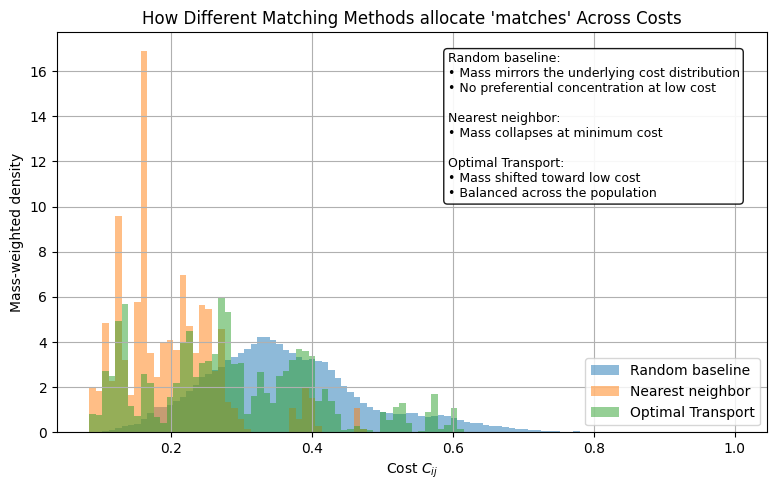

In [ ]:
def plot_mass_weighted_cost_hist(Pi_rand, Pi_nn, Pi_ot, C, bins=100):
    # Flatten everything
    C_flat = C.ravel()
    Pr = Pi_rand.ravel()
    Pn = Pi_nn.ravel()
    Po = Pi_ot.ravel()

    plt.figure(figsize=(8,5))

    plt.hist(
        C_flat, bins=bins, weights=Pr,
        alpha=0.5, density=True, label="Random baseline"
    )
    plt.hist(
        C_flat, bins=bins, weights=Pn,
        alpha=0.5, density=True, label="Nearest neighbor"
    )
    plt.hist(
        C_flat, bins=bins, weights=Po,
        alpha=0.5, density=True, label="Optimal Transport"
    )

    plt.xlabel("Cost $C_{ij}$")
    plt.ylabel("Mass-weighted density")
    plt.title("How Different Matching Methods allocate 'matches' Across Costs")
    plt.legend()
    plt.grid(True)

        # --- Interpretation box ---
    text = (
        "Random baseline:\n"
        "• Mass mirrors the underlying cost distribution\n"
        "• No preferential concentration at low cost\n\n"
        "Nearest neighbor:\n"
        "• Mass collapses at minimum cost\n\n"
        "Optimal Transport:\n"
        "• Mass shifted toward low cost\n"
        "• Balanced across the population"
    )

    plt.text(
        0.55, 0.95, text,
        transform=plt.gca().transAxes,
        fontsize=9,
        va="top",
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.9)
    )


    plt.tight_layout()
    plt.show()

plot_mass_weighted_cost_hist(Pi_rand, Pi_nn, Pi, C, bins=100)



This figure shows how different matching methods allocate transport mass across pairwise costs. The random baseline assigns mass independently of cost, so its distribution simply reflects the natural distribution of distances. Nearest-neighbor matching collapses mass onto the lowest-cost pairs, ignoring global balance. Optimal transport shifts mass toward low-cost pairs while maintaining balanced participation across the population.


### How evenly does each method distribute participation across women?

C:\Users\salmank\AppData\Local\Temp\ipykernel_17708\4258920207.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


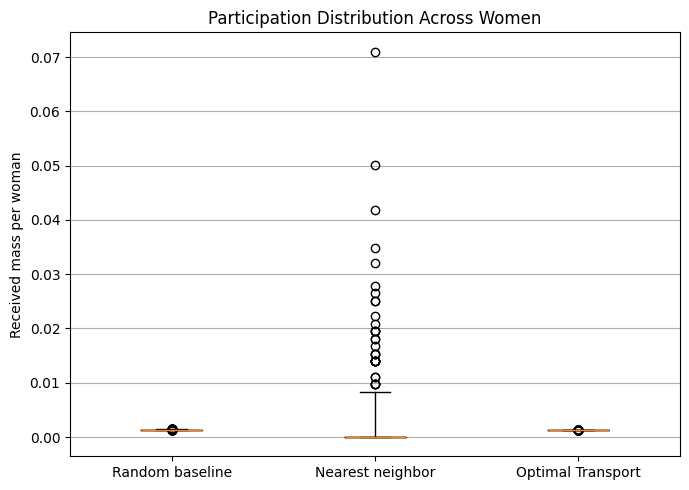

In [ ]:
def plot_participation_boxplot(Pi_rand, Pi_nn, Pi_ot):
    r_rand = Pi_rand.sum(axis=0)
    r_nn   = Pi_nn.sum(axis=0)
    r_ot   = Pi_ot.sum(axis=0)

    data = [r_rand, r_nn, r_ot]
    labels = ["Random baseline", "Nearest neighbor", "Optimal Transport"]

    plt.figure(figsize=(7,5))
    plt.boxplot(
        data,
        labels=labels,
        showfliers=True,
        whis=(5, 95)
    )

    plt.ylabel("Received mass per woman")
    plt.title("Participation Distribution Across Women")
    plt.grid(True, axis="y")
    plt.tight_layout()
    plt.show()

plot_participation_boxplot(Pi_rand, Pi_nn, Pi)



The box plot summarizes how participation is distributed across individuals. Nearest-neighbor matching produces extreme imbalance, with many individuals receiving no mass, while optimal transport tightly concentrates participation around the target level.
